# In this script I am creating an advanced model named A-CNN (Absolute-CNN) for the processed dataset. The Absolute CNN is a model that is built upon the AANN model -> https://openreview.net/pdf?id=rkhxwltab
-------------------------------------------------------------------------------------------------------------------
# Technology used: Tensorflow

### Start with importing the usual cells for my tasks

In [1]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# for pickling the data
import cPickle as pickle

# THE TensorFlow framework
import tensorflow as tf

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

Data
LICENSE
Localizer
Models
README.md
Scripts



In [4]:
np.random.seed(3) # set this seed for a device independant consistent behaviour

In [5]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../Data" # the data path

data_files_path = {
    "train": os.path.join(data_path, "train"),
    "test" : os.path.join(data_path, "test")
}

base_model_path = "../Models"
plug_and_play_data_file = os.path.join(data_path, "plug_and_play.pickle")

labels_csv_file = os.path.join(data_path, "labels.csv")

# constants for the preprocessing script
im_dim = 128; n_channels = 3 # RGB images
patch_size = 32 # we look at 32 x 32 sized patches to generate the representation vectors
fixed_resize = (im_dim, im_dim, n_channels)
batch_size = 64 # 64 images in each batch
highest_pixel_value = 255 # since color channels are 8 bits.
train_percentage = 95
neurons_in_attention_generator = 512 # 512 neurons in attention generator
num_filters = 64 # number of filters in the network
no_of_epochs = 100
checkpoint_factor = 5 # save model after 5 epochs

# Use the unpickler function from the helpers repository to get the processed data into memory:
link to code -> https://github.com/akanimax/machine-learning-helpers/blob/master/pickling_unpickling/pickling_operations.py

In [6]:
# function to unpickle the given file and load the obj back into the python environment
def unPickleIt(pickle_path): # might throw the file not found exception
    '''
        function to unpickle the object from the given path
        @param
        pickle_path => the path where the pickle file is located
        @return => the object extracted from the saved path
    '''

    with open(pickle_path, 'rb') as dumped_pickle:
        obj = pickle.load(dumped_pickle)

    return obj # return the unpickled object

In [7]:
processed_data = unPickleIt(plug_and_play_data_file)

In [8]:
train_X = processed_data['train_X']
train_Y = np.squeeze(processed_data['train_Y'])
test_X = processed_data['test_X']
test_Y = np.squeeze(processed_data['test_Y'])
labels_dict = processed_data['labels_dict']
reverse_labels_dict = processed_data['reverse_labels_dict']

In [9]:
# shape sanity checking
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((9711, 128, 128, 3), (9711,), (511, 128, 128, 3), (511,))

In [10]:
# extract the number of class labels 
num_labels = len(labels_dict)

run the following cell multiple times in order to check if the data is still sanitized. Also, use google to see the real breed information if not known.

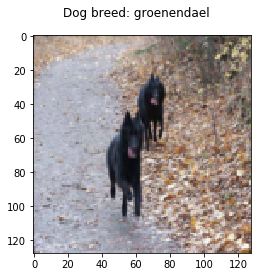

In [11]:
random_index = np.random.randint(train_X.shape[0])
random_image = train_X[random_index]
label_for_random_image = train_Y[random_index]

# plot the entire image in one piece:
plt.figure().suptitle("Dog breed: " + reverse_labels_dict[label_for_random_image])
plt.imshow(random_image);

### Use this point to restart the cell running if something goes wrong while creating the graph below

In [12]:
# reset point for the graph:
tf.reset_default_graph()

### Define the input placeholders and the one hot label encoder

In [13]:
# define the placeholders for the input images and their corresponding labels:
with tf.variable_scope("Input_placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, im_dim, im_dim, n_channels), name="Raw_input_images")
    tf_input_summary = tf.summary.image("Input_Images", tf_input, max_outputs=10)
    
    tf_labels = tf.placeholder(tf.int32, shape=(None,), name="Ideal_breed_labels")

In [14]:
tf_input, tf_labels

(<tf.Tensor 'Input_placeholders/Raw_input_images:0' shape=(?, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'Input_placeholders/Ideal_breed_labels:0' shape=(?,) dtype=int32>)

### Define the attention generator network

In [15]:
with tf.variable_scope("Attention_mask_generator"):
    # reshape the input image to a flat vector
    
    flat_vector_shape = im_dim * im_dim * n_channels
    
    attention_input = tf.reshape(tf_input, 
                              shape=[-1, flat_vector_shape], name="Attention_network_input")
    
    # apply a few dense layers with ReLU (*Note the usage of ReLU activation function*)
    at_lay_1 = tf.layers.dense(attention_input, neurons_in_attention_generator, activation=tf.nn.relu, 
                              kernel_initializer=tf.truncated_normal_initializer(mean=0.5, stddev=0.5),
                              name="dense_layer_1")
    
    at_lay_2 = tf.layers.dense(at_lay_1, neurons_in_attention_generator, activation=tf.nn.relu, 
                              kernel_initializer=tf.truncated_normal_initializer(mean=0.5, stddev=0.5),
                              name="dense_layer_2")
    
    at_lay_3 = tf.layers.dense(at_lay_2, flat_vector_shape, activation=tf.nn.relu, 
                              kernel_initializer=tf.truncated_normal_initializer(mean=0.5, stddev=0.5),
                              name="dense_layer_3")
    
    # The attention mask:
    attention_mask = tf.nn.sigmoid(at_lay_3, name="Sigmoid")
    
    # reshape the attention mask to the original image size
    reshaped_attention_mask = tf.reshape(attention_mask, shape=[-1, im_dim, im_dim, n_channels])

### Check the shapes of all the intermediate tensors

In [16]:
attention_input

<tf.Tensor 'Attention_mask_generator/Attention_network_input:0' shape=(?, 49152) dtype=float32>

In [17]:
at_lay_1, at_lay_2, at_lay_3

(<tf.Tensor 'Attention_mask_generator/dense_layer_1/Relu:0' shape=(?, 512) dtype=float32>,
 <tf.Tensor 'Attention_mask_generator/dense_layer_2/Relu:0' shape=(?, 512) dtype=float32>,
 <tf.Tensor 'Attention_mask_generator/dense_layer_3/Relu:0' shape=(?, 49152) dtype=float32>)

In [18]:
attention_mask, reshaped_attention_mask

(<tf.Tensor 'Attention_mask_generator/Sigmoid:0' shape=(?, 49152) dtype=float32>,
 <tf.Tensor 'Attention_mask_generator/Reshape:0' shape=(?, 128, 128, 3) dtype=float32>)

### Define the Computations for the Attention mechanism

In [19]:
# use the attention mask to create an attention on the input image
with tf.variable_scope("Attention_masker"):
    # This is just elementwise multiplication
    tf_attention_masked_input = tf.multiply(tf_input, reshaped_attention_mask)
    
    # create a summary op on this image to see what the network is focussing it's attention on right now
    tf_attention_masked_input_summary = tf.summary.image("Attention_Masked_Input", 
                                                         tf_attention_masked_input, max_outputs=10)

In [20]:
tf_attention_masked_input

<tf.Tensor 'Attention_masker/Mul:0' shape=(?, 128, 128, 3) dtype=float32>

### Use the one hot encoder to encode the avaliable labels

In [21]:
with tf.variable_scope("One_hot_encoder"):
    # one hot encode the input labels
    one_hot_encoded_tf_labels = tf.one_hot(tf_labels, depth=num_labels, axis=1, name="One_hot_Encode")

In [22]:
# check the dimensions and types of the input placeholder:
tf_attention_masked_input, one_hot_encoded_tf_labels

(<tf.Tensor 'Attention_masker/Mul:0' shape=(?, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'One_hot_encoder/One_hot_Encode:0' shape=(?, 120) dtype=float32>)

### Define the Encoder and decoder functions

Define the convolutional encoder for generating the representations from the masked image 

In [23]:
def encode(images, w_reuse=None):
    '''
        Function to encode the input images into representation vectors
        @param 
        images => tensor containing the input images to be trained on
        reuse => Boolean controlling reuse of weights 
        @return => Encoded_representation_vector
    '''
    # set a name scope here so that we end up using the same weights and biases for the infernce mode 
    # and the decoding part:
    with tf.name_scope("Encoder"):
        
        # The low level feature extractors: input of (128 x 128)  running depth of (64)
        a1 = tf.layers.conv2d(images, num_filters, kernel_size=(3, 3), 
                              padding="same", activation=tf.abs, name = "layer_1", reuse=w_reuse)
        
        a2 = tf.layers.conv2d(a1, num_filters, kernel_size=(3, 3), 
                              padding="same", activation=tf.abs, name = "layer_2", reuse=w_reuse)
        
        a3 = tf.layers.conv2d(a2, num_filters, kernel_size=(3, 3), strides=(2, 2), # This will halve the dimensions
                              padding="same", activation=tf.abs, name = "layer_3", reuse=w_reuse)
        
        
        # The mid level features extractors: input of (64 x 64) running  depth of (128)
        a4 = tf.layers.conv2d(a3, (2 * num_filters), kernel_size=(5, 5),
                              padding="same", activation=tf.abs, name = "layer_4", reuse=w_reuse)
        
        a5 = tf.layers.conv2d(a4, (2 * num_filters), kernel_size=(5, 5),
                              padding="same", activation=tf.abs, name = "layer_5", reuse=w_reuse)
        
        a6 = tf.layers.conv2d(a5, (2 * num_filters), kernel_size=(5, 5), strides=(2, 2),
                              padding="same", activation=tf.abs, name = "layer_6", reuse=w_reuse)
        
        
        # The high level features extractors: input of (32 x 32) running  depth of (256)
        a7 = tf.layers.conv2d(a6, (4 * num_filters), kernel_size=(7, 7), 
                              padding="same", activation=tf.abs, name = "layer_7", reuse=w_reuse)
        
        a8 = tf.layers.conv2d(a7, (4 * num_filters), kernel_size=(7, 7), 
                              padding="same", activation=tf.abs, name = "layer_8", reuse=w_reuse)
        
        a9 = tf.layers.conv2d(a8, (4 * num_filters), kernel_size=(7, 7), 
                              padding="same", activation=tf.abs, name = "layer_9", reuse=w_reuse)
        
        
        # The Representation vector creator layers: input of (32 x 32) running  depth of (512)
        a10 = tf.layers.conv2d(a9, (8 * num_filters), kernel_size=(8, 8), 
                              padding="same", activation=tf.abs, name = "layer_10", reuse=w_reuse)
        
        a11 = tf.layers.conv2d(a10, (8 * num_filters), kernel_size=(16, 16), 
                              padding="same", activation=tf.abs, name = "layer_11", reuse=w_reuse)
        
        a12 = tf.layers.conv2d(a11, num_labels, kernel_size=(32, 32), 
                              padding="valid", activation=tf.abs, name = "layer_12", reuse=w_reuse)
        
        # obtain the representation vector from the a12 activations by reshaping that tensor
        representations = tf.reshape(a12, shape=(-1, num_labels))
        
    return representations

Define the deconvolutional decoder for generating the original image from the representation vector

In [24]:
def decode(reps, w_reuse=True):
    '''
        Function to encode the input images into representation vectors
        @param 
        reps => tensor containing the learned representation vectors to be deconvolved
        reuse => Boolean controlling reuse of weights 
        @return => Encoded_representation_vector
    '''
    with tf.name_scope("Decoder"):
        
        # reshape representation_vectors into an activation map
        deconv_input = tf.reshape(reps, shape=(-1, 1, 1, num_labels))
        
        # The superficial feature drawers: input of (1 x 1)
        a1 = tf.layers.conv2d_transpose(deconv_input, (8 * num_filters), kernel_size=(32, 32), use_bias=False,
                              padding="valid", activation=tf.abs, name = "layer_12", reuse=w_reuse)
        
        a2 = tf.layers.conv2d_transpose(a1, (8 * num_filters), kernel_size=(16, 16), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_11", reuse=w_reuse)
        
        a3 = tf.layers.conv2d_transpose(a2, (4 * num_filters), kernel_size=(8, 8), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_10", reuse=w_reuse)
        
        
        # The high level feature drawers: input of (32 x 32)
        a4 = tf.layers.conv2d_transpose(a3, (4 * num_filters), kernel_size=(7, 7), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_8", reuse=w_reuse)
        
        a5 = tf.layers.conv2d_transpose(a4, (4 * num_filters), kernel_size=(7, 7), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_9", reuse=w_reuse)
        
        a6 = tf.layers.conv2d_transpose(a5, (2 * num_filters), kernel_size=(7, 7), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_7", reuse=w_reuse)
        
        
        # The mid level feture drawers: converted input of (64 x 64)
        a7 = tf.layers.conv2d_transpose(a6, (2 * num_filters), kernel_size=(5, 5), use_bias=False, strides=(2, 2),
                              padding="same", activation=tf.abs, name = "layer_6", reuse=w_reuse)
        
        a8 = tf.layers.conv2d_transpose(a7, (2 * num_filters), kernel_size=(5, 5), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_5", reuse=w_reuse)
        
        a9 = tf.layers.conv2d_transpose(a8, num_filters, kernel_size=(5, 5), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_4", reuse=w_reuse)
        
        
        # The lowest (fine details) feature drawers: converted input of (128 x 128)
        a10 = tf.layers.conv2d_transpose(a9, num_filters, kernel_size=(3, 3), use_bias=False, strides=(2, 2),
                              padding="same", activation=tf.abs, name = "layer_3", reuse=w_reuse)
        
        a11 = tf.layers.conv2d_transpose(a10, num_filters, kernel_size=(3, 3), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_2", reuse=w_reuse)
        
        a12 = tf.layers.conv2d_transpose(a11, n_channels, kernel_size=(3, 3), use_bias=False,
                              padding="same", activation=tf.abs, name = "layer_1", reuse=w_reuse)
        
    # return the final generated image to compare it with the original
    return a12

### Define the functions used for computing the losses

In [25]:
def directional_cosines(inp):
    '''
        function to convert input tensor into it's corresponding directional cosine values
    '''
    with tf.variable_scope("Directional_cosines"):
        squared = tf.square(inp) # square all the numbers
        denominator = tf.reduce_sum(squared, axis=1, keep_dims=True)
        dc = inp / denominator
    
    # return the directional cosine values
    return dc

In [26]:
def euclidean_distance(tensor1, tensor2):
    '''
        function to compute the euclidean distances between two tensors
        It is assumed that the batch dimension is the first one
    '''
    with tf.variable_scope("Euclidean_distance"):
        diff = tensor1 - tensor2
        sqrd_diff = tf.square(diff)
        sums = tf.reduce_sum(sqrd_diff, axis=1, keep_dims=True)
        distances = tf.sqrt(sums)
    
    # return the computed euclidean distances:
    return distances

### Define the Training and Inference Computations

In [27]:
with tf.variable_scope("Training_computations"):
    # obtain the encoded representation vectors:
    reps = encode(tf_attention_masked_input)
    
    # convert the reps to directional cosines
    dcs = directional_cosines(reps)
    
    # send the reps back into the deconv network to obtain the reconstructed image
    reverse_maps = decode(reps)
    reverse_maps_summary = tf.summary.image("Reverse_constructed_image", reverse_maps, max_outputs=10)

In [28]:
# check the dimensions of all three
reps, dcs, reverse_maps

(<tf.Tensor 'Training_computations/Encoder/Reshape:0' shape=(?, 120) dtype=float32>,
 <tf.Tensor 'Training_computations/Directional_cosines/div:0' shape=(?, 120) dtype=float32>,
 <tf.Tensor 'Training_computations/Decoder/layer_1/Abs:0' shape=(?, 128, 128, 3) dtype=float32>)

### Define the Forward, Backward and the total loss

In [34]:
with tf.variable_scope("Losses"):
    with tf.name_scope("forward_loss"):
        fwd_loss = tf.reduce_mean(euclidean_distance(dcs, one_hot_encoded_tf_labels))
        fwd_loss_summary = tf.summary.scalar("Forward_loss", fwd_loss)
        
    with tf.name_scope("reverse_loss"):
        # flatten the reverse map and the attention masked input image
        flat_reverse_maps = tf.reshape(reverse_maps, shape=(-1, (im_dim * im_dim * n_channels)))
        flat_tf_attention_masked_input = tf.reshape(tf_attention_masked_input, 
                                                    shape=(-1, (im_dim * im_dim * n_channels)))
        
        bwd_loss = tf.reduce_mean(euclidean_distance(flat_reverse_maps, flat_tf_attention_masked_input))
        bwd_loss_summary = tf.summary.scalar("Reverse_loss", bwd_loss)
        
    with tf.name_scope("combined_loss"):
        total_loss = fwd_loss + bwd_loss
        total_loss_summary = tf.summary.scalar("Total_loss", total_loss)

In [35]:
fwd_loss, bwd_loss, total_loss

(<tf.Tensor 'Losses_2/forward_loss/Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'Losses_2/reverse_loss/Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'Losses_2/combined_loss/add:0' shape=() dtype=float32>)

### Define the Inference computations for image generation

### Define the optimizer for optimizing the loss

### Define the usual errands

In [ ]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Use a fake session and check if the graph is properly wired using the tensorboard visualizer

In [ ]:
model_name = "Model1"
log_dir = os.path.join(base_model_path, model_name)
log_dir

## Make sure the folder Model1 is empty before executing the following cell, otherwise, it will create duplicate event files and will cause tensorboard to raise warnings.
-------------------------------------------------------------------------------------------------------------------
## I also print out all the trainable variables in the graph to be sure that during inference also, we use the trained variables and not some newly created ones.

In [ ]:
with tf.Session() as sess:
    tensorboard_writer = tf.summary.FileWriter(logdir=log_dir, graph=sess.graph, filename_suffix=".bot")
    
    # initialize the session to generate the visualization file
    sess.run(init)
    
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)
    
    for var, val in zip(tvars, tvars_vals):
        print(var.name)

# We can now write the session Code for training this graph

## The training loop for this hybrid model:

In [ ]:
model_path = log_dir
print os.path.join(model_path, model_name)

In [ ]:
num_train_examples = train_X.shape[0]
print num_train_examples

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session() as sess:
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 0
    for ep in range(no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
            
        for index in range(int(np.ceil(float(num_train_examples) / batch_size))):
            start = index * batch_size
            end = start + batch_size
            minX = train_X[start: end]; minY = np.squeeze(train_Y[start: end])
                
            _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
            if(index % 50 == 0):
                print('range:{} loss= {}'.format((start, start + len(minX)), loss))
            
            g_step += 1
                
        print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, model_name), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="